<a href="https://colab.research.google.com/github/ad71/ragbot/blob/master/agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG with Agents
An agent-based approach to perform question answering over multiple documents in an orchestrated fashion. Compare different documents, summarize a specific document or compare various summaries.
Agentic RAG is a flexible approach and framework to question answering.

Here we use agents instead of a LLM directly to accomplish a set of tasks which requires planning, multi-step reasoning, tool use and/or learning over time.

## Basic Architecture
The basic architecture is to setup a **document agent** of each of the documents, with each **document agent** being able to perform question answering and summarization within its own document.

Then a top-leve agent (meta-agent) is setup managing all of the lower order document agents.

Tech stack:
1. Langchain - LCEL
2. OpenAI
3. FAISS-CPU

In [1]:
%pip install -qU langchain langchain_openai langgraph arxiv duckduckgo_search==5.3.1b1
%pip install -qU faiss-cpu pymupdf grandalf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.9 MB/s eta 0:00

In [2]:
from google.colab import userdata
from uuid import uuid4
import os

#
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['LANGCHAIN_TRACING_v2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = f'AIE1 - LangGraph - {uuid4().hex[0:8]}'
# os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import ArxivLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

In [3]:
docs = ArxivLoader(query='Retrieval Augmented Generation', load_max_docs=5).load()

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=350, chunk_overlap=50)
chunked_documents = text_splitter.split_documents(docs)

embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
faiss_vectorstore = FAISS.from_documents(documents=chunked_documents, embedding=embeddings)

retriever = faiss_vectorstore.as_retriever()

ImportError: PyMuPDF package not found, please install it with `pip install pymupdf`

In [ ]:
RAG_PROMPT = '''
Use the following context to answer the user's query. If you cannot answer the question, please respond with "I don't know".

Question:
{question}

Context:
{context}
'''

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [ ]:
# instantiate the LLM
openai_chat_model = ChatOpenAI(model='gpt-3.5-turbo')

## Build LCEL RAG chain

In [30]:
retrieval_augmented_generation_chain = (
    {'context': itemgetter('question')
    | retriever, 'question': itemgetter('question')}
    | RunnablePassthrough.assign(context=itemgetter('context'))
    | {'response': rag_prompt | openai_chat_model, 'context': itemgetter('context')}
)

retrieval_augmented_generation_chain

{
  context: RunnableLambda(itemgetter('question'))
           | VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7e679c4f2500>),
  question: RunnableLambda(itemgetter('question'))
}
| RunnableAssign(mapper={
    context: RunnableLambda(itemgetter('context'))
  })
| {
    response: ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nUse the following context to answer the user\'s query. If you cannot answer the question, please respond with "I don\'t know".\n\nQuestion:\n{question}\n\nContext:\n{context}\n'))])
              | ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7e679a0abdc0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7e67a3391300>, openai_api_key=SecretStr('**********'), openai_proxy=''),
    context: RunnableLambda

In [31]:
await retrieval_augmented_generation_chain.ainvoke({'question': 'What is Retrieval Augmented Generation?'})

{'response': AIMessage(content='Retrieval Augmented Generation is a text generation paradigm that combines deep learning technology with traditional retrieval methods. It has shown remarkable advantages and achieved state-of-the-art performance in various natural language processing tasks. The paradigm involves generating text based on retrieved human-written references rather than starting from scratch, which can make text generation easier. It utilizes retrieval sources, retrieval metrics, and generation models as key components to enhance the generation process.', response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 2187, 'total_tokens': 2271}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-7a0af69a-e21e-4754-bff5-1219b1f8cd73-0'),
 'context': [Document(page_content='grating translation memory to NMT models (Gu\net al., 2018; Zhang et al., 2018; Xu et al., 2020;\nHe et al., 2021). We also review 

## Tool belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a load of tools in the LangChain Community Repo but we'll stick to a couple so we can observe the cyclic nature of LangGraph in action

We're using
- DuckDuckGo web search
- Arxiv

In [4]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langgraph.prebuilt import ToolExecutor

tool_belt = [
    DuckDuckGoSearchRun(),
    ArxivQueryRun()
]

tool_executor = ToolExecutor(tool_belt)

In [5]:
# instantiate openai function calling
from langchain_core.utils.function_calling import convert_to_openai_function
model = ChatOpenAI(temperature=0)
functions = [convert_to_openai_function(t) for t in tool_belt]
model = model.bind_functions(functions)
model

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7fcc4dc6dbd0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7fcc4dc6f970>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy=''), kwargs={'functions': [{'name': 'duckduckgo_search', 'description': 'A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query']}}, {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'type': 'object', 'properties': {'q

## LangGraph
LangGraph leverages a StatefulGraph which uses an AgentState object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this AgentState object is one that is stored in a TypeDict with the key messages and the value is a Sequence of BaseMessages that will be appended to whenever the state changes.

In [6]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

`call_model`: calls the model

`call_tool`: calls a tool

In [7]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

def call_model(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {'messages': [response]}

def call_tool(state):
    last_message = state['messages'][-1]

    action = ToolInvocation(
        tool=last_message.additional_kwargs['function_call']['name'],
        tool_input=json.loads(
            last_message.additional_kwargs['function_call']['arguments']
        )
    )

    response = tool_executor.invoke(action)
    function_message = FunctionMessage(content=str(response), name=action.tool)

    return {'messages': [function_message]}

In [8]:
# build the workflow
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node('agent', call_model)
workflow.add_node('action', call_tool)
workflow.nodes

{'agent': agent(recurse=True), 'action': action(recurse=True)}

In [9]:
workflow.set_entry_point('agent')

In [10]:
# build a conditional edge for routing
def should_continue(state):
    last_message = state['messages'][-1]

    if 'function_call' not in last_message.additional_kwargs:
        return 'end'

    return 'continue'

workflow.add_conditional_edges(
    'agent',
    should_continue,
    {
        'continue': 'action',
        'end': END
    }
)

In [11]:
# finally connect the conditional edge to the agent node and action node
workflow.add_edge('action', 'agent')

In [12]:
# compile the workflow
app = workflow.compile()
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x7fcc800e7cc0>, skip_none=False, mapper=_get_state_key(recurse=False))]), ChannelWrite<start:agent>(recurse=True, writes=[ChannelWriteEntry(channel='start:agent', value='__start__', skip_none=False, mapper=None)])]), 'agent': PregelNode(config={'tags': []}, channels={'messages': 'messages'}, triggers=['start:agent', 'action'], mapper=functools.partial(<function _coerce_state at 0x7fcc4e3b9ab0>, <class '__main__.AgentState'>), writers=[ChannelWrite<agent,messages>(recurse=True, writes=[ChannelWriteEntry(channel='agent', value='agent', skip_none=False, mapper=None), ChannelWriteEntry(channel='messages', value=<object object at 0x7fcc800e7cc0>, skip_none=False, mapper=_get_state_key(recurse=False))]), _route(recurse=True, _is_channel_write

In [13]:
# app.get_graph().print_ascii()
# print(app.get_graph().draw_mermaid())

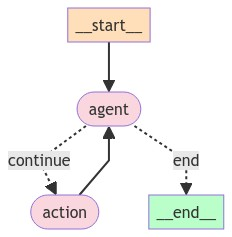

In [14]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
# invoke the langgraph - ask query
from langchain_core.messages import HumanMessage

inputs = {'messages': [HumanMessage(content='What is RAG in the context of Large Language Models? When did it break onto the scene?')]}

response = app.invoke(inputs)
print(response)

{'messages': [HumanMessage(content='What is RAG in the context of Large Language Models? When did it break onto the scene?'), AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"RAG in the context of Large Language Models"}', 'name': 'duckduckgo_search'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 171, 'total_tokens': 196}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-a5a200fe-fd4e-4488-b5de-ab7f5d1dcae8-0'), FunctionMessage(content='Large language models (LLMs) are incredibly powerful tools for processing and generating text. However, they inherently struggle to understand the broader context of information, especially when dealing with lengthy conversations or complex tasks. This is where large context windows and Retrieval-Augmented Generation (RAG) come into play. February 2024 marked a pivotal moment in the AI field as Google unveiled Gemini 

In [18]:
response

{'messages': [HumanMessage(content='What is RAG in the context of Large Language Models? When did it break onto the scene?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"RAG in the context of Large Language Models"}', 'name': 'duckduckgo_search'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 171, 'total_tokens': 196}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-a5a200fe-fd4e-4488-b5de-ab7f5d1dcae8-0'),
  FunctionMessage(content='Large language models (LLMs) are incredibly powerful tools for processing and generating text. However, they inherently struggle to understand the broader context of information, especially when dealing with lengthy conversations or complex tasks. This is where large context windows and Retrieval-Augmented Generation (RAG) come into play. February 2024 marked a pivotal moment in the AI field as Google unveiled Gem

In [20]:
response['messages'][-1].content

'In the context of Large Language Models, RAG stands for Retrieval-Augmented Generation. RAG is a technique used to "ground" large language models with specific data sources, often sources that were not included in the models\' original training data. RAG helps LLMs understand the broader context of information, especially in dealing with lengthy conversations or complex tasks.\n\nRAG broke onto the scene in February 2024 when Google unveiled Gemini 1.5 Pro, which boasted an impressive 1 million tokens of context capacity. This advancement in the AI field reignited the discourse on the relevance of RAG in an era dominated by Large Context Models. The debate between RAG and Long Context Large Language Models has since garnered significant attention in the rapidly evolving landscape of language models.'

In [22]:
question = 'Who is the main author on the Retrieval Augmented Generation paper - and what university did they attend?'

inputs = {'messages': [HumanMessage(content=question)]}

response = app.invoke(inputs)
response['messages'][-1].content

'The main author on the "Retrieval Augmented Generation" paper is Huayang Li. Unfortunately, the university they attended is not mentioned in the summary provided.'

In [23]:
response

{'messages': [HumanMessage(content='Who is the main author on the Retrieval Augmented Generation paper - and what university did they attend?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"Retrieval Augmented Generation"}', 'name': 'arxiv'}}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 172, 'total_tokens': 191}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-3e0cfa98-1b73-4cd5-9de6-87fe8cddaff1-0'),
  FunctionMessage(content="Published: 2022-02-13\nTitle: A Survey on Retrieval-Augmented Text Generation\nAuthors: Huayang Li, Yixuan Su, Deng Cai, Yan Wang, Lemao Liu\nSummary: Recently, retrieval-augmented text generation attracted increasing attention\nof the computational linguistics community. Compared with conventional\ngeneration models, retrieval-augmented text generation has remarkable\nadvantages and particularly has achieved state-of-t

In [24]:
question = 'Who is the main author on the Retrieval Augmented Generation paper?'

inputs = {'messages': [HumanMessage(content=question)]}

response = app.invoke(inputs)
response['messages'][-1].content

'The main authors on the "Retrieval Augmented Generation" paper are Huayang Li, Yixuan Su, Deng Cai, Yan Wang, and Lemao Liu.'